In [1]:
#https://drive.google.com/file/d/1tmj_GRKzcGZE_7n8lQLXiWoInzxRjuuc/view?usp=sharing
!gdown 1tmj_GRKzcGZE_7n8lQLXiWoInzxRjuuc

Downloading...
From: https://drive.google.com/uc?id=1tmj_GRKzcGZE_7n8lQLXiWoInzxRjuuc
To: /content/train.csv
100% 643k/643k [00:00<00:00, 105MB/s]


In [2]:
import numpy as np
import pandas as pd

x = pd.read_csv('train.csv', delimiter=',', encoding = 'unicode_escape')

X = x.drop(columns=['Rating'])
y = x['Rating']
print(X.shape)
x.head()

(2351, 4)


,Id,Hotel_name,Review_Title,Review_Text,Rating
0,0,Park Hyatt,Refuge in Chennai,Excellent room and exercise facility. All arou...,80.0
1,1,Hilton Chennai,Hilton Chennai,Very comfortable and felt safe. \r\nStaff were...,100.0
2,2,The Royal Regency,No worth the rating shown in websites. Pricing...,Not worth the rating shown. Service is not goo...,71.0
3,3,Rivera,Good stay,"First of all nice & courteous staff, only one ...",86.0
4,4,Park Hyatt,Needs improvement,Overall ambience of the hotel is very good. In...,86.0


In [3]:
X.isna().sum()

Id                0
Hotel_name        0
Review_Title    215
Review_Text       0
dtype: int64

Заменим все nan пустой строкой

In [4]:
X = X.fillna('') 

**Очистка текста**

Очистим текст от знаков препинания и специальных символов, а затем переведём всё это в нижний регистр

In [5]:
from nltk.tokenize import word_tokenize
import re
import nltk
import matplotlib.pyplot as plt

In [6]:
def cleaning_data(data):
  clean_txt = []
  for w in range(len(data.Review_Text)):
    desc = data.iloc[w]['Review_Text'].lower()

    #удаляем пунктуацию
    desc = re.sub('[^a-zA-Z]', ' ', desc)

    #удаляем теги
    desc=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",desc)

    #удаление цифр и специальных символов
    desc=re.sub("(\\d|\\W)+"," ",desc)
    clean_txt.append(desc)

  data['clean_Review_Text'] = clean_txt


  clean_txt = []
  for w in range(len(data.Review_Title)):
    desc = data.iloc[w]['Review_Title'].lower()

    #удаляем пунктуацию
    desc = re.sub('[^a-zA-Z]', ' ', desc)

    #удаляем теги
    desc=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",desc)

    #удаление цифр и специальных символов
    desc=re.sub("(\\d|\\W)+"," ",desc)
    clean_txt.append(desc)

  data['clean_Review_Title'] = clean_txt
  return data

X = cleaning_data(X)
X.head()

,Id,Hotel_name,Review_Title,Review_Text,clean_Review_Text,clean_Review_Title
0,0,Park Hyatt,Refuge in Chennai,Excellent room and exercise facility. All arou...,excellent room and exercise facility all aroun...,refuge in chennai
1,1,Hilton Chennai,Hilton Chennai,Very comfortable and felt safe. \r\nStaff were...,very comfortable and felt safe staff were very...,hilton chennai
2,2,The Royal Regency,No worth the rating shown in websites. Pricing...,Not worth the rating shown. Service is not goo...,not worth the rating shown service is not good...,no worth the rating shown in websites pricing ...
3,3,Rivera,Good stay,"First of all nice & courteous staff, only one ...",first of all nice courteous staff only one con...,good stay
4,4,Park Hyatt,Needs improvement,Overall ambience of the hotel is very good. In...,overall ambience of the hotel is very good in ...,needs improvement


**Уменьшение словаря**

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
from nltk.corpus import stopwords
sw_eng = set(stopwords.words('english'))

In [9]:
def deleting_stop_words(data):
  clean_txt = []
  for w in range(len(data.clean_Review_Text)):
    sent = data.iloc[w]['clean_Review_Text']

    clean_sent = ' '.join([word for word in sent.split() if not word in sw_eng])
    clean_txt.append(clean_sent)

  data['clean_Review_Text'] = clean_txt


  clean_txt = []
  for w in range(len(data.clean_Review_Title)):
    sent = data.iloc[w]['clean_Review_Title']

    clean_sent = ' '.join([word for word in sent.split() if not word in sw_eng])
    clean_txt.append(clean_sent)

  data['clean_Review_Title'] = clean_txt  
  return data

X = deleting_stop_words(X)
X.head()

,Id,Hotel_name,Review_Title,Review_Text,clean_Review_Text,clean_Review_Title
0,0,Park Hyatt,Refuge in Chennai,Excellent room and exercise facility. All arou...,excellent room exercise facility around atmosp...,refuge chennai
1,1,Hilton Chennai,Hilton Chennai,Very comfortable and felt safe. \r\nStaff were...,comfortable felt safe staff helpful respectful...,hilton chennai
2,2,The Royal Regency,No worth the rating shown in websites. Pricing...,Not worth the rating shown. Service is not goo...,worth rating shown service good room well main...,worth rating shown websites pricing ok
3,3,Rivera,Good stay,"First of all nice & courteous staff, only one ...",first nice courteous staff one con stay time c...,good stay
4,4,Park Hyatt,Needs improvement,Overall ambience of the hotel is very good. In...,overall ambience hotel good room facilities ne...,needs improvement


**Лемматизация**

In [10]:
from nltk import wordnet, pos_tag

def get_wordnet_pos(treebank_tag):
    my_switch = {
        'J': wordnet.wordnet.ADJ,
        'V': wordnet.wordnet.VERB,
        'N': wordnet.wordnet.NOUN,
        'R': wordnet.wordnet.ADV,
    }
    for key, item in my_switch.items():
        if treebank_tag.startswith(key):
            return item
    return wordnet.wordnet.NOUN

In [11]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [12]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
from nltk import WordNetLemmatizer

def my_lemmatizer(sent):
    lemmatizer = WordNetLemmatizer()
    tokenized_sent = sent.split()
    pos_tagged = [(word, get_wordnet_pos(tag))
                 for word, tag in pos_tag(tokenized_sent)]
    return ' '.join([lemmatizer.lemmatize(word, tag)
                    for word, tag in pos_tagged])

In [14]:
def lemmatization(data):
  normalized_txt = []
  for w in range(len(data.clean_Review_Text)):
    sent = data.iloc[w]['clean_Review_Text']

    normalized_sent = my_lemmatizer(sent)
    normalized_txt.append(normalized_sent)

  data['clean_Review_Text'] = normalized_txt


  normalized_txt = []
  for w in range(len(data.clean_Review_Title)):
    sent = data.iloc[w]['clean_Review_Title']

    normalized_sent = my_lemmatizer(sent)
    normalized_txt.append(normalized_sent)

  data['clean_Review_Title'] = normalized_txt
  return data

X = lemmatization(X)
X.head()

,Id,Hotel_name,Review_Title,Review_Text,clean_Review_Text,clean_Review_Title
0,0,Park Hyatt,Refuge in Chennai,Excellent room and exercise facility. All arou...,excellent room exercise facility around atmosp...,refuge chennai
1,1,Hilton Chennai,Hilton Chennai,Very comfortable and felt safe. \r\nStaff were...,comfortable felt safe staff helpful respectful...,hilton chennai
2,2,The Royal Regency,No worth the rating shown in websites. Pricing...,Not worth the rating shown. Service is not goo...,worth rating show service good room well maint...,worth rating show website price ok
3,3,Rivera,Good stay,"First of all nice & courteous staff, only one ...",first nice courteous staff one con stay time c...,good stay
4,4,Park Hyatt,Needs improvement,Overall ambience of the hotel is very good. In...,overall ambience hotel good room facility need...,need improvement


**Токенизация**

Попробуем токенизировать отзывы и подсчитывать количество токенов для каждого отзыва

In [15]:
X["tokens"] = X["clean_Review_Text"].map(lambda text: re.sub(r"[^a-zA-Z0-9' ]", ' ', text)).map(lambda text: text.split())

In [16]:
X["tokens"]

0       [excellent, room, exercise, facility, around, ...
1       [comfortable, felt, safe, staff, helpful, resp...
2       [worth, rating, show, service, good, room, wel...
3       [first, nice, courteous, staff, one, con, stay...
4       [overall, ambience, hotel, good, room, facilit...
                              ...                        
2346    [impressive, service, staff, area, good, resta...
2347    [new, woodland, chennai, give, homely, experie...
2348    [awesome, like, neatness, maintenance, facilit...
2349    [overall, experience, good, however, wi, fi, g...
2350    [cool, luxurious, cottage, stay, family, coupl...
Name: tokens, Length: 2351, dtype: object

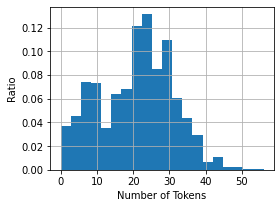

In [17]:
num_train = X.shape[0]

X["num_tokens"] = X["tokens"].map(len)
ax = X["num_tokens"].hist(bins=20, 
                                 figsize=(4,3),
                                 weights=np.ones(num_train)/num_train)
ax.set_xlabel("Number of Tokens")
ax.set_ylabel("Ratio")
plt.show()

In [18]:
print(len(X[X["num_tokens"] < 35]) / len(X["num_tokens"]))

0.9204593789876648


Из результата мы видим, что в большинстве отзывов меньше 35 токенов.

**Negative, positive words**

In [19]:
def find_pos_neg_words(data):
  for w in range(len(data.clean_Review_Text)):
    text = data.iloc[w]['clean_Review_Text']
    pos_count = 0
    neg_count = 0

    for word in text.split():
      with open('positive-words.txt', encoding = "ISO-8859-1") as file:
        if word in file.read():
          pos_count += 1

      with open('negative-words.txt', encoding = "ISO-8859-1") as file:
        if word in file.read():
          neg_count += 1
      
    data.loc[ w ,'Pos_count'] = pos_count
    data.loc[ w ,'Neg_count'] = neg_count


  for w in range(len(data.clean_Review_Title)):
    text = data.iloc[w]['clean_Review_Title']
    pos_count = 0
    neg_count = 0

    for word in text.split():
      with open('positive-words.txt', encoding = "ISO-8859-1") as file:
        if word in file.read():
          pos_count += 1

      with open('negative-words.txt', encoding = "ISO-8859-1") as file:
        if word in file.read():
          neg_count += 1
      
    data.loc[ w ,'Pos_count_in_title'] = pos_count
    data.loc[ w ,'Neg_count_in_title'] = neg_count

  return data

X = find_pos_neg_words(X)
X.head()

,Id,Hotel_name,Review_Title,Review_Text,clean_Review_Text,clean_Review_Title,tokens,num_tokens,Pos_count,Neg_count,Pos_count_in_title,Neg_count_in_title
0,0,Park Hyatt,Refuge in Chennai,Excellent room and exercise facility. All arou...,excellent room exercise facility around atmosp...,refuge chennai,"[excellent, room, exercise, facility, around, ...",23,8.0,4.0,0.0,0.0
1,1,Hilton Chennai,Hilton Chennai,Very comfortable and felt safe. \r\nStaff were...,comfortable felt safe staff helpful respectful...,hilton chennai,"[comfortable, felt, safe, staff, helpful, resp...",17,7.0,7.0,0.0,0.0
2,2,The Royal Regency,No worth the rating shown in websites. Pricing...,Not worth the rating shown. Service is not goo...,worth rating show service good room well maint...,worth rating show website price ok,"[worth, rating, show, service, good, room, wel...",28,12.0,9.0,4.0,5.0
3,3,Rivera,Good stay,"First of all nice & courteous staff, only one ...",first nice courteous staff one con stay time c...,good stay,"[first, nice, courteous, staff, one, con, stay...",21,11.0,9.0,1.0,0.0
4,4,Park Hyatt,Needs improvement,Overall ambience of the hotel is very good. In...,overall ambience hotel good room facility need...,need improvement,"[overall, ambience, hotel, good, room, facilit...",23,8.0,5.0,1.0,1.0


In [20]:
from sklearn.model_selection import train_test_split

X_new = X.drop(columns=['Id', 'Review_Title', 'Review_Text', 'clean_Review_Text', 'clean_Review_Title', 'tokens'])
X_new = pd.get_dummies(X_new, columns = ['Hotel_name'])

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y, test_size=0.3, shuffle=True, random_state=42)

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

clf = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            random_state=0,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            n_jobs=-1)

clf.fit(X_train_new, y_train_new)
np.mean(cross_val_score(clf, X_test_new, y_test_new, cv=5, scoring='accuracy'))

0.2732893816801518

Как и ожидалось - без дополнительных признаков получилось очень плохо

In [22]:
X.head()

,Id,Hotel_name,Review_Title,Review_Text,clean_Review_Text,clean_Review_Title,tokens,num_tokens,Pos_count,Neg_count,Pos_count_in_title,Neg_count_in_title
0,0,Park Hyatt,Refuge in Chennai,Excellent room and exercise facility. All arou...,excellent room exercise facility around atmosp...,refuge chennai,"[excellent, room, exercise, facility, around, ...",23,8.0,4.0,0.0,0.0
1,1,Hilton Chennai,Hilton Chennai,Very comfortable and felt safe. \r\nStaff were...,comfortable felt safe staff helpful respectful...,hilton chennai,"[comfortable, felt, safe, staff, helpful, resp...",17,7.0,7.0,0.0,0.0
2,2,The Royal Regency,No worth the rating shown in websites. Pricing...,Not worth the rating shown. Service is not goo...,worth rating show service good room well maint...,worth rating show website price ok,"[worth, rating, show, service, good, room, wel...",28,12.0,9.0,4.0,5.0
3,3,Rivera,Good stay,"First of all nice & courteous staff, only one ...",first nice courteous staff one con stay time c...,good stay,"[first, nice, courteous, staff, one, con, stay...",21,11.0,9.0,1.0,0.0
4,4,Park Hyatt,Needs improvement,Overall ambience of the hotel is very good. In...,overall ambience hotel good room facility need...,need improvement,"[overall, ambience, hotel, good, room, facilit...",23,8.0,5.0,1.0,1.0


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.metrics import classification_report

In [25]:
def evaluate_model_Xy(model, X, y, y_pred=None, label="Training", model_name="model"):
  if y_pred is None:
    y_pred = model.predict(X)

  print(label + ' Set')
  print("Accuracy:", accuracy_score(y, y_pred))
  print()

  print(classification_report(y, y_pred, digits=4))
  print()

In [26]:
def evaluate_model(model, df_train, df_test, y_train, y_test, model_name="model",
                   y_train_pred=None, y_test_pred=None):
  evaluate_model_Xy(model, df_train, y_train, label="Training", model_name=model_name)
  evaluate_model_Xy(model, df_test, y_test, label="Testing", model_name=model_name)

**Vectorization**

TfidfVectorizer

In [27]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def extract_features(df_train, df_test, y_train, y_test):
  vectorizer = TfidfVectorizer(analyzer='word', 
                               stop_words='english',
                               ngram_range=(1, 2),
                               lowercase=True,
                               min_df=5,
                               binary=False)
  X_train_tf = vectorizer.fit_transform(df_train["clean_Review_Text"])
  X_test_tf = vectorizer.transform(df_test["clean_Review_Text"])

  y_train_tf = y_train.tolist()
  y_test_tf = y_test.tolist()
  
  return X_train_tf, X_test_tf, y_train_tf, y_test_tf

In [28]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = extract_features(X_train, X_test, y_train, y_test)

In [29]:
X_train_tf

<1645x1503 sparse matrix of type '<class 'numpy.float64'>'
	with 31972 stored elements in Compressed Sparse Row format>

CountVectorizer

In [30]:
def extract_features2(df_train, df_test, y_train, y_test):
  vectorizer = CountVectorizer(analyzer='word', 
                               stop_words='english',
                               ngram_range=(1, 2),
                               lowercase=True,
                               min_df=5,
                               binary=False)
  X_train_cv = vectorizer.fit_transform(df_train["clean_Review_Text"])
  X_test_cv = vectorizer.transform(df_test["clean_Review_Text"])

  y_train_cv = y_train.tolist()
  y_test_cv = y_test.tolist()
  
  return X_train_cv, X_test_cv, y_train_cv, y_test_cv

In [31]:
X_train_cv, X_test_cv, y_train_cv, y_test_cv = extract_features2(X_train, X_test, y_train, y_test)

In [32]:
X_train_cv

<1645x1503 sparse matrix of type '<class 'numpy.int64'>'
	with 31972 stored elements in Compressed Sparse Row format>

**Пробуем решить задачу классификации**

Тест для TfidfVectorizer

In [33]:
clf_lr = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            random_state=0,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            n_jobs=-1)

clf_lr.fit(X_train_tf, y_train_tf)
evaluate_model(clf_lr, X_train_tf, X_test_tf, y_train_tf, y_test_tf, model_name='lr')

Training Set
Accuracy: 0.956838905775076

              precision    recall  f1-score   support

        20.0     1.0000    0.9677    0.9836        62
        29.0     0.9630    1.0000    0.9811        52
        40.0     1.0000    0.9286    0.9630        56
        43.0     1.0000    0.9661    0.9828        59
        57.0     0.9898    0.9417    0.9652       103
        60.0     0.9741    0.9741    0.9741       116
        65.0     1.0000    0.7876    0.8812       113
        71.0     0.9574    0.9657    0.9615       233
        80.0     0.9469    0.9640    0.9554       222
        86.0     0.9341    0.9905    0.9615       315
       100.0     0.9352    0.9650    0.9498       314

    accuracy                         0.9568      1645
   macro avg     0.9728    0.9501    0.9599      1645
weighted avg     0.9582    0.9568    0.9563      1645


Testing Set
Accuracy: 0.5155807365439093

              precision    recall  f1-score   support

        20.0     0.5652    0.5000    0.5306    

Test for CountVectorizer

In [34]:
clf_lr = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            random_state=0,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            n_jobs=-1)

clf_lr.fit(X_train_cv, y_train_cv)
evaluate_model(clf_lr, X_train_cv, X_test_cv, y_train_cv, y_test_cv, model_name='lr')

Training Set
Accuracy: 0.9860182370820668

              precision    recall  f1-score   support

        20.0     1.0000    0.9839    0.9919        62
        29.0     1.0000    1.0000    1.0000        52
        40.0     1.0000    0.9464    0.9725        56
        43.0     1.0000    1.0000    1.0000        59
        57.0     1.0000    0.9806    0.9902       103
        60.0     0.9915    1.0000    0.9957       116
        65.0     0.9811    0.9204    0.9498       113
        71.0     1.0000    0.9957    0.9978       233
        80.0     0.9250    1.0000    0.9610       222
        86.0     1.0000    0.9905    0.9952       315
       100.0     0.9936    0.9873    0.9904       314

    accuracy                         0.9860      1645
   macro avg     0.9901    0.9822    0.9859      1645
weighted avg     0.9868    0.9860    0.9861      1645


Testing Set
Accuracy: 0.5339943342776204

              precision    recall  f1-score   support

        20.0     0.4800    0.4615    0.4706   

**Пробуем решить задачу регрессии**

Тест для TfidfVectorizer

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

clf_lr = LinearRegression(fit_intercept=True, n_jobs=-1)
clf_lr.fit(X_train_tf, y_train_tf)
np.mean(cross_val_score(clf_lr, X_test_tf, y_test_tf, cv=cv, scoring='r2', n_jobs=-1))

0.10045276771535874

Test for CountVectorizer

In [36]:
clf_lr = LinearRegression(fit_intercept=True, n_jobs=-1)
clf_lr.fit(X_train_cv, y_train_cv)
np.mean(cross_val_score(clf_lr, X_test_cv, y_test_cv, cv=cv, scoring='r2', n_jobs=-1))

-0.8085996152550445

Если рассматривать эту задачу как задачу регресии, то получается совсем плохо. Поэтому в дальнейшем, мне кажется, есть смысл строить только модели классификации

**Word2vec**

In [37]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9 MB 1.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [38]:
import spacy

# Загружаем большую модель, чтобы получить векторы
nlp = spacy.load('en_core_web_lg')

spaCy вычисляет средний вектор для всего документа, который мы можем получить с помощью doc.vector

In [39]:
with nlp.disable_pipes():
    doc_vectors = np.array([nlp(text).vector for text in X.clean_Review_Text])
    
doc_vectors.shape

(2351, 300)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(doc_vectors, y, test_size=0.3, shuffle=True, random_state=42)

In [41]:
from sklearn.svm import LinearSVC

svc = LinearSVC(max_iter=10000, random_state=42)
svc.fit(X_train, y_train)
evaluate_model(svc, X_train, X_test, y_train, y_test, model_name="svc")

Training Set
Accuracy: 0.7045592705167173

              precision    recall  f1-score   support

        20.0     0.8923    0.9355    0.9134        62
        29.0     0.8913    0.7885    0.8367        52
        40.0     0.9231    0.8571    0.8889        56
        43.0     0.8810    0.6271    0.7327        59
        57.0     0.8103    0.4563    0.5839       103
        60.0     0.7619    0.6897    0.7240       116
        65.0     0.8352    0.6726    0.7451       113
        71.0     0.5953    0.5494    0.5714       233
        80.0     0.7149    0.7793    0.7457       222
        86.0     0.6143    0.7079    0.6578       315
       100.0     0.6776    0.7898    0.7294       314

    accuracy                         0.7046      1645
   macro avg     0.7816    0.7139    0.7390      1645
weighted avg     0.7144    0.7046    0.7030      1645


Testing Set
Accuracy: 0.41359773371104813

              precision    recall  f1-score   support

        20.0     0.3333    0.3462    0.3396  

In [43]:
clf_lr = LogisticRegression(C=1000.0,
                            fit_intercept=True,
                            random_state=42,
                            max_iter=10000,
                            n_jobs=-1)

clf_lr.fit(X_train, y_train)
evaluate_model(clf_lr, X_train, X_test, y_train, y_test, model_name="lr")

Training Set
Accuracy: 0.9306990881458966

              precision    recall  f1-score   support

        20.0     1.0000    1.0000    1.0000        62
        29.0     1.0000    1.0000    1.0000        52
        40.0     1.0000    0.9821    0.9910        56
        43.0     1.0000    1.0000    1.0000        59
        57.0     0.9796    0.9320    0.9552       103
        60.0     0.9915    1.0000    0.9957       116
        65.0     0.9730    0.9558    0.9643       113
        71.0     0.8728    0.8541    0.8633       233
        80.0     0.9404    0.9955    0.9672       222
        86.0     0.8652    0.8762    0.8707       315
       100.0     0.9288    0.9140    0.9213       314

    accuracy                         0.9307      1645
   macro avg     0.9592    0.9554    0.9572      1645
weighted avg     0.9308    0.9307    0.9306      1645


Testing Set
Accuracy: 0.4830028328611898

              precision    recall  f1-score   support

        20.0     0.2800    0.2692    0.2745   

Итак, судя по проведённым опытам, лучше всего себя показал CountVectorizer